In [52]:
import s3fs
import pandas as pd
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "jhajjar"
FILE_PATH_S3 = f"{MY_BUCKET}/Diffusion/post_processed_listings.csv"
with fs.open(FILE_PATH_S3, "r") as file_in:
    listings = pd.read_csv(file_in)

listings

,id,Type,Nb_chambre,loc,surface,prix
0,apimo-85473173,Appartement,1,Châtelet,29,364000
1,hektor-Les-4-Quartiers-383,Appartement,1,Châtelet,23,301000
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,Palais Royal,106,2490000
3,ag754594-448898324,Studio,1,Saint-Germain,27,365000
4,keller-williams-1-34_1_53-180645,Appartement,2,Vendôme,67,1190000
...,...,...,...,...,...,...
8825,apimo-6951400,Appartement,4,Plaine,89,599000
8826,apimo-6810785,Appartement,2,Gambetta,40,302000
8827,immo-facile-49166437,Appartement,3,Père Lachaise,67,769000
8828,immo-facile-48762452,Appartement,3,Télégraphe,57,519000


Nettoyage + simplification

array([[<Axes: xlabel='Nb_chambre', ylabel='Nb_chambre'>,
        <Axes: xlabel='surface', ylabel='Nb_chambre'>,
        <Axes: xlabel='prix', ylabel='Nb_chambre'>,
        <Axes: xlabel='prix/surface', ylabel='Nb_chambre'>],
       [<Axes: xlabel='Nb_chambre', ylabel='surface'>,
        <Axes: xlabel='surface', ylabel='surface'>,
        <Axes: xlabel='prix', ylabel='surface'>,
        <Axes: xlabel='prix/surface', ylabel='surface'>],
       [<Axes: xlabel='Nb_chambre', ylabel='prix'>,
        <Axes: xlabel='surface', ylabel='prix'>,
        <Axes: xlabel='prix', ylabel='prix'>,
        <Axes: xlabel='prix/surface', ylabel='prix'>],
       [<Axes: xlabel='Nb_chambre', ylabel='prix/surface'>,
        <Axes: xlabel='surface', ylabel='prix/surface'>,
        <Axes: xlabel='prix', ylabel='prix/surface'>,
        <Axes: xlabel='prix/surface', ylabel='prix/surface'>]],
      dtype=object)

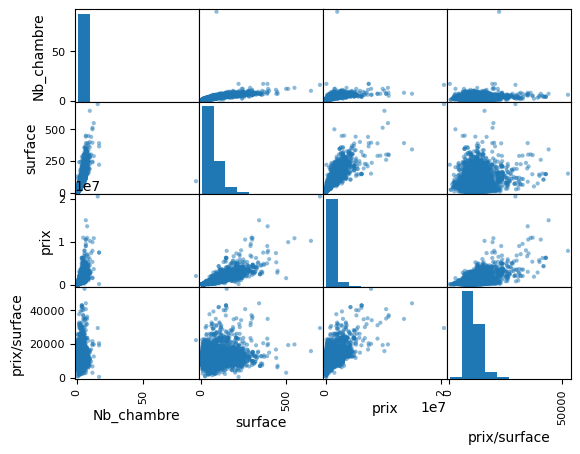

In [53]:
listings.dropna(inplace=True)
listings["prix/surface"] = listings["prix"] / listings["surface"]
pd.plotting.scatter_matrix(listings)


In [59]:

listings = listings[listings["Nb_chambre"]<50]
listings["prix/surface par pièce"] = listings["prix/surface"]/listings["Nb_chambre"]
quantile_sup_psp = listings["prix/surface par pièce"].quantile(0.95)
quantile_inf_psp = listings["prix/surface par pièce"].quantile(0.05)
quantile_sup_ps = listings["prix/surface"].quantile(0.95)
quantile_inf_ps = listings["prix/surface"].quantile(0.05)
quantile_sup_p = listings["prix/surface"].quantile(0.95)
quantile_inf_p = listings["prix/surface"].quantile(0.05)
listings = listings[(listings["prix/surface par pièce"]>=quantile_inf_psp) & (listings["prix/surface par pièce"]>=quantile_inf_psp)]
listings = listings[(listings["prix/surface"]>=quantile_inf_ps) & (listings["prix/surface"]>=quantile_inf_ps)]
listings = listings[(listings["prix/surface"]>=quantile_inf_p) & (listings["prix/surface"]>=quantile_inf_p)]
#pd.plotting.scatter_matrix(listings)

listings[listings["Nb_chambre"]>14]

,Type,Nb_chambre,surface,prix,prix/surface,prix/surface par pièce


array([[<Axes: xlabel='Nb_chambre', ylabel='Nb_chambre'>,
        <Axes: xlabel='surface', ylabel='Nb_chambre'>,
        <Axes: xlabel='prix', ylabel='Nb_chambre'>,
        <Axes: xlabel='prix/surface', ylabel='Nb_chambre'>,
        <Axes: xlabel='prix/surface par pièce', ylabel='Nb_chambre'>],
       [<Axes: xlabel='Nb_chambre', ylabel='surface'>,
        <Axes: xlabel='surface', ylabel='surface'>,
        <Axes: xlabel='prix', ylabel='surface'>,
        <Axes: xlabel='prix/surface', ylabel='surface'>,
        <Axes: xlabel='prix/surface par pièce', ylabel='surface'>],
       [<Axes: xlabel='Nb_chambre', ylabel='prix'>,
        <Axes: xlabel='surface', ylabel='prix'>,
        <Axes: xlabel='prix', ylabel='prix'>,
        <Axes: xlabel='prix/surface', ylabel='prix'>,
        <Axes: xlabel='prix/surface par pièce', ylabel='prix'>],
       [<Axes: xlabel='Nb_chambre', ylabel='prix/surface'>,
        <Axes: xlabel='surface', ylabel='prix/surface'>,
        <Axes: xlabel='prix', ylabel='pr

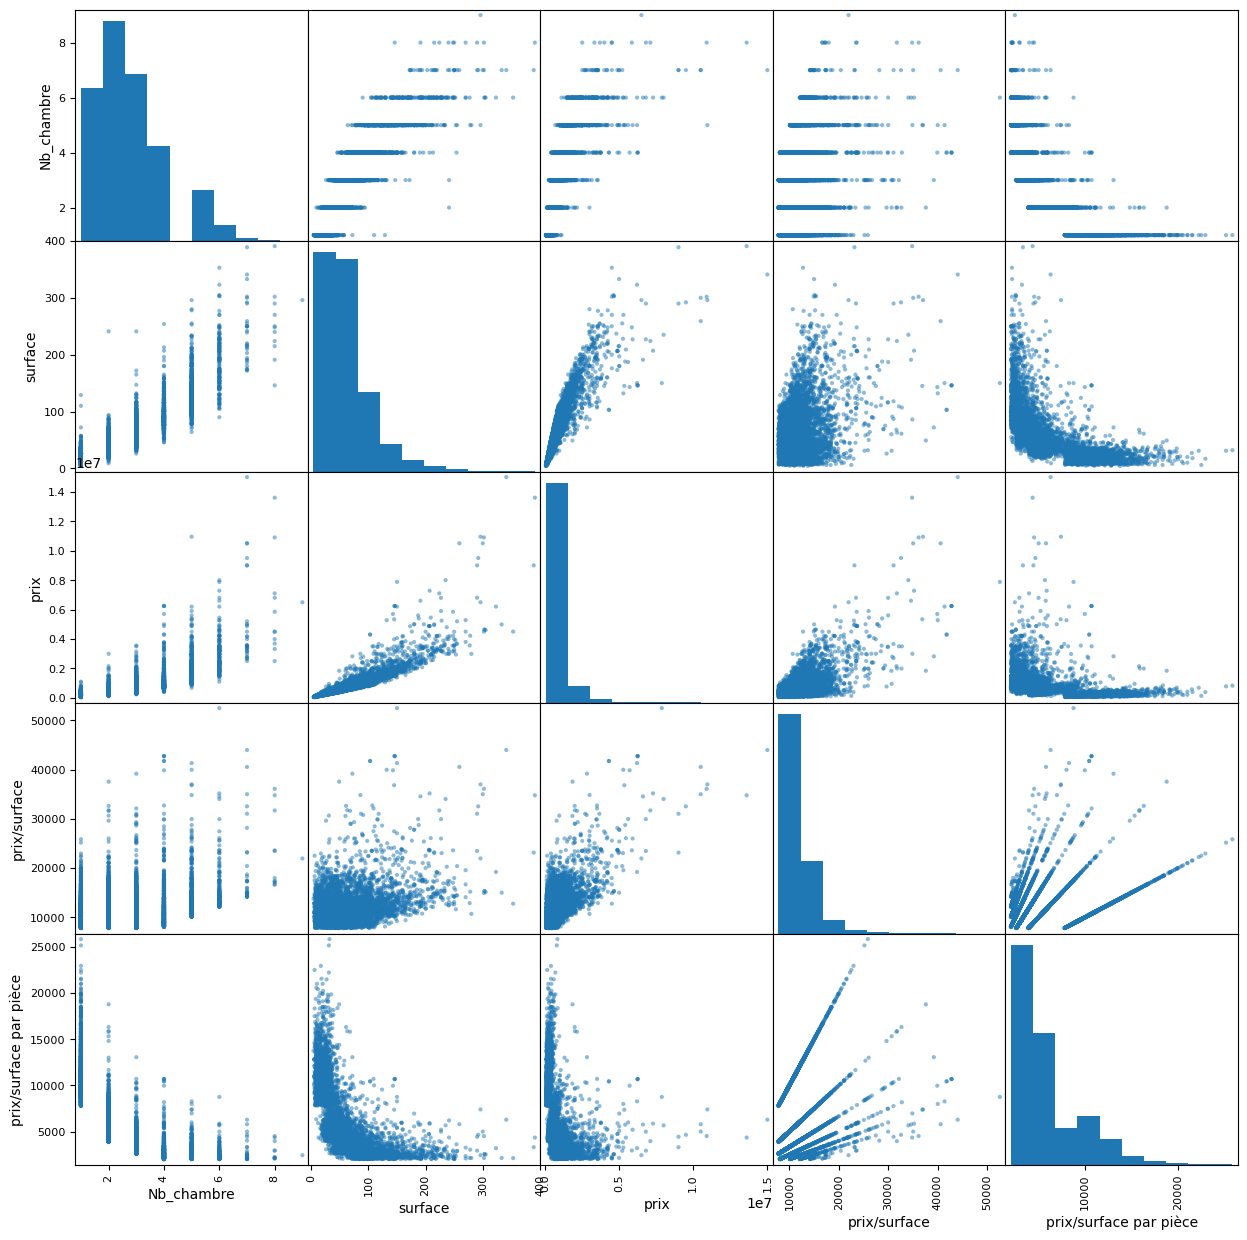

In [62]:
listings.dropna(inplace=True)

pd.plotting.scatter_matrix(listings,figsize=(15, 15))


In [56]:
listings = listings.drop(['id','loc'],axis=1)

Description des colonnes "number of rooms", "sqm2" et "price"

In [57]:
listings[['Nb_chambre', 'surface', 'prix']].describe().round(2)


,Nb_chambre,surface,prix
count,8114.00,8114.00,8114.00
mean,2.73,64.01,774637.03
std,1.43,46.51,848704.20
min,1.00,4.00,42000.00
25%,2.00,32.00,330000.00
50%,2.00,52.00,549000.00
75%,4.00,82.00,895000.00
max,16.00,699.00,20550000.00


Le sample est donc de 9358 observations ce qui nous permet de faire des interprétations sans se baser sur un échantillon qui manquerait de représentativité. Cependant la ville de Paris sur laquelle nous nous focalisons comporte en elle-même un biais par rapport aux autres villes françaises(centre économique, centre politique, centre culturel et dimension internationale).
La moyenne (806 740€) est sensiblement plus élevé que la médiane (565 000€) ce qui suppose que la distribution de prix est biaisé. Le prix de quelques propriétés tirent à la hausse la moyenne. Cela peut paraître logique, la ville de Paris étant connu pour son immobilier de luxe, prisée par des investisseurs internationaux. Le maximum de 20 millions d'euros confirme cette disparité dans les prix.

In [58]:
listings["price/sqm2"] = listings["price"] / listings["sqm2"]
listings = listings[listings["price/sqm2"]>4500]
listings = listings[listings['Type'] != 'Loft/atelier/surface']
listings[['Number_of_rooms', 'sqm2', 'price','price/sqm2']].describe().round(2)


KeyError: 'price'